In [1]:
import copy
import csv
import cvxpy
import datetime
import json
import math
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import multiprocessing
from multiprocessing import Pool
import numpy as np
import os
import pandas as pd
import pickle
import random
import seaborn as sns
from typing import List, Dict
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
sys.path.append('../')

from skyburst import Job
from skyburst.plot import *
from skyburst import utils

In [2]:

sim_df = utils.load_logs_as_dataframe('/home/gcpuser/sim_logs/philly/vary_deadline.log')

In [3]:
print(sim_df.keys())

Index(['idx', 'arrival', 'start', 'runtime', 'deadline', 'num_gpus', 'state',
       'allocated_gpus', 'cluster_size', 'gpus_per_node', 'cpus_per_node',
       'sched_alg', 'binpack_alg', 'waiting_policy', 'waiting_factor',
       'backfill', 'loop', 'predict_wait', 'filter_alg', 'verbose', 'debug',
       'pbar_idx', 'warmup_jobs', 'dataset', 'arrival_rate', 'total_jobs',
       'total_cloud_cost', 'avg_cloud_cost', 'avg_waiting', 'avg_jct',
       'cluster_utilization', 'system_utilization'],
      dtype='object')


In [176]:
def set_plotting_setting(ax):
    plt.rcParams.update({'font.size': 15})
    ax.grid(True, which='both')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.set_xlim(right=2.25)

label_dict = {
    'avg_jct': 'Avg. JCT (hr)',
    'cost_mult': '% Cost Savings\nover No Wait',
    'cost_diff': 'Cost Savings\nover No Wait',
    'cluster_size': 'Cluster Size (# Nodes)',
    'norm_system_utilization': 'System Utilization',
    'system_utilization': 'System Utilization',
    'cluster_utilization': 'Cluster Utilization',
    'total_cloud_cost': 'Cloud Cost',
    'arrival_rate': 'Arrival Rate',
}

def simulator_plotting_fn(df, 
                          x_axis: str,
                          y_axis: list = ['cost_mult', 'avg_jct'],
                          df_filter: dict = {},
                          baseline_filter: dict={'waiting_policy': 'zero',},
                          groupby_values=['waiting_policy', 'waiting_factor'],
                          normalize_x_axis=False):
    if isinstance(y_axis, str):
        y_axis = [y_axis]
    fig, axs = plt.subplots(nrows=1, ncols=len(y_axis), figsize=(5*len(y_axis), 3.5))
    
    for k,v in df_filter.items():
        df = df[df[k]==v]
       
    baseline_df = df
    for k,v in baseline_filter.items():
        assert isinstance(v, str)
        baseline_df = baseline_df[baseline_df[k]==v]
        #df = df[df[k]!=v]
    diff_df = pd.merge(df, baseline_df, left_on=x_axis,right_on=x_axis)
    
    if normalize_x_axis:
        if x_axis == 'cluster_size':
            # Hardcoded in Philly trace, precomputed ahead of time
            total_job_volume = 1155998.77277777
            job_makespan = 2559.3205555555555
            diff_df['norm_system_utilization'] = total_job_volume/(job_makespan*diff_df['cluster_size']*sim_df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
        elif x_axis == 'arrival_rate':
            avg_job_volume_rate = diff_df['arrival_rate'] * np.mean(df['num_gpus'].iloc[0]* df['runtime'].iloc[0])
            diff_df['norm_system_utilization'] = avg_job_volume_rate/(df['cluster_size'].iloc[0]*df['gpus_per_node'].iloc[0])
            x_axis = 'norm_system_utilization'
    
    def cost_multiplier(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        if baseline_cost == 0 and cost==0:
            return 0
        elif baseline_cost <=10000:
            # Small cloud cost for No wait
            # Savings over small cloud cost is negligible for organizations.
            return 0
        elif baseline_cost == 0 and cost>0:
            return 100
        return 100* (1 - (cost/baseline_cost))
    
    def cost_difference(row):
        baseline_cost = row['total_cloud_cost_y']
        cost = row['total_cloud_cost_x']
        return baseline_cost - cost
    
    diff_df['cost_mult'] = diff_df.apply(cost_multiplier, axis=1)
    diff_df['cost_diff'] = diff_df.apply(cost_difference, axis=1)
    groupby_values = [f'{g}_x' for g in groupby_values]
    mod_y_axis = [f'{y}_x' if y!='cost_mult' and y!='cost_diff' else y for y in y_axis]
    import itertools
    markers = itertools.cycle(('v', '^','.', 'o', '*',',', '+',)) 
    for idx, (label, grp) in enumerate(diff_df.groupby(groupby_values)):
        marker = next(markers)
        for ax_idx, ax in enumerate(axs):           
            grp.plot(x = x_axis, y = mod_y_axis[ax_idx],ylabel=label_dict[y_axis[ax_idx]], \
                     xlabel=label_dict[x_axis], marker=marker, ax = ax, label = label, legend=None)
    
    for ax in axs:
        set_plotting_setting(ax)
    #axs[1].set_xlim(right=36, left=20)
    lines, labels = ax.get_legend_handles_labels()
    fig.legend(lines, labels, ncol=len(labels), \
               bbox_to_anchor=(0, 0.92, 1, 0.2),loc='upper center')
    plt.tight_layout()
    plt.show()  

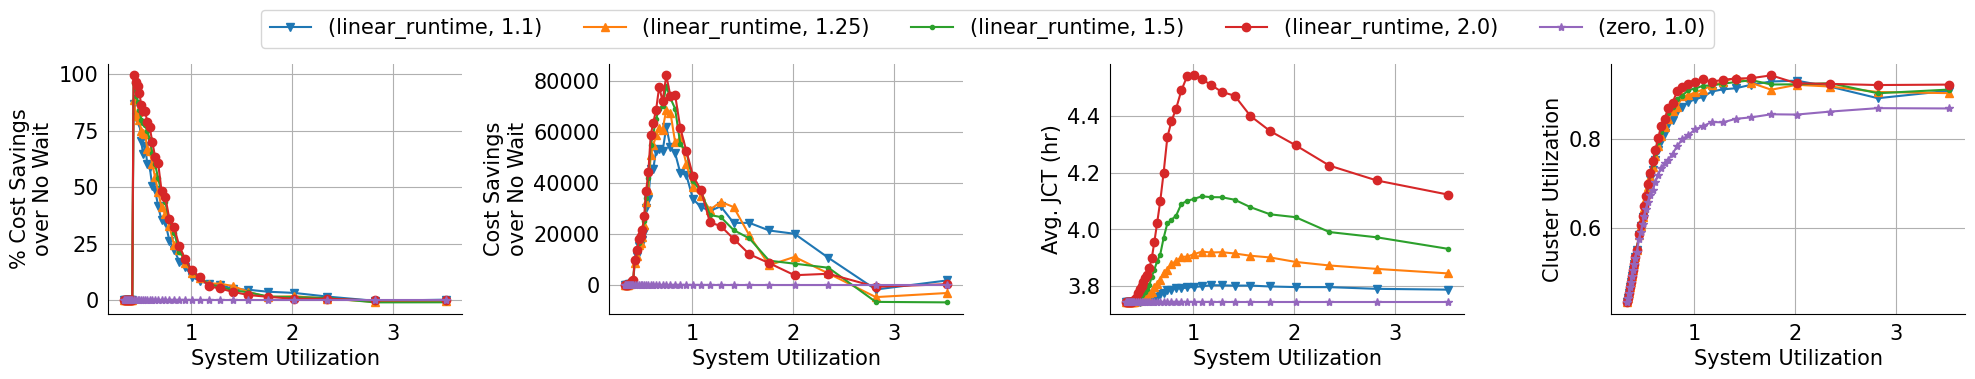

In [113]:
simulator_plotting_fn(sim_df, x_axis='cluster_size', y_axis=['cost_mult','cost_diff','avg_jct','cluster_utilization'], normalize_x_axis=True)

In [153]:
arrival_df = utils.load_logs_as_dataframe('/home/gcpuser/sim_logs/gen_gpu/vary_waiting_5.log')

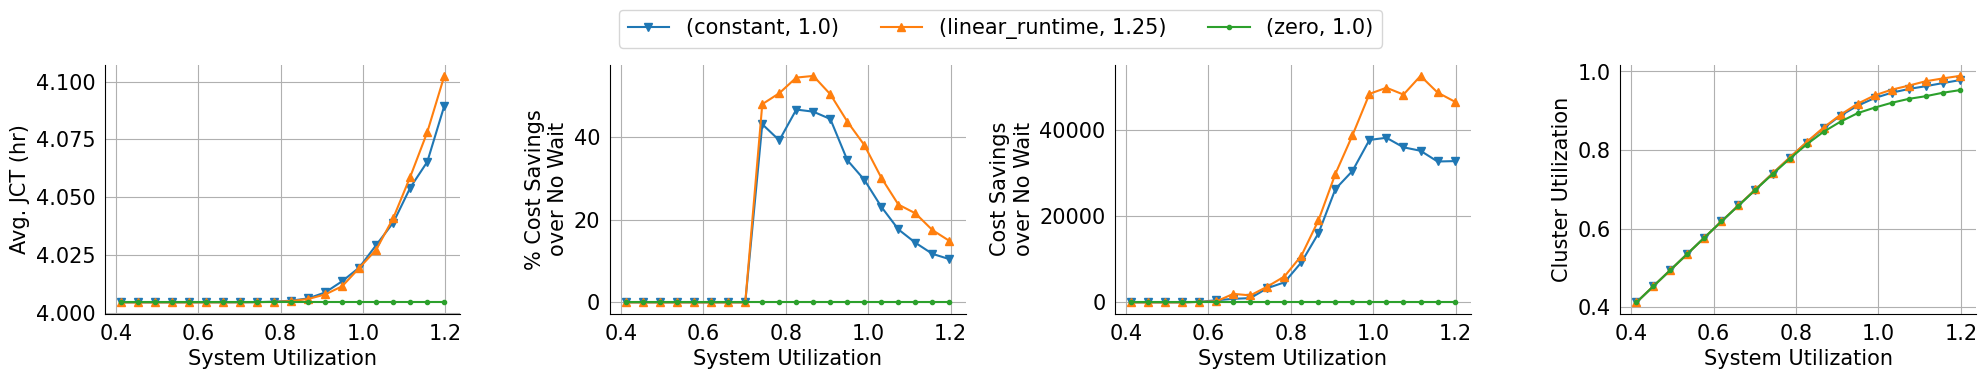

In [159]:
simulator_plotting_fn(arrival_df, x_axis='arrival_rate', y_axis=['avg_jct','cost_mult', 'cost_diff', 'cluster_utilization'], \
                      groupby_values=['waiting_policy', 'waiting_factor'], normalize_x_axis=True)

In [155]:
asdf = arrival_df[arrival_df['waiting_policy']=='linear_runtime']
np.sum(asdf['deadline'][58] - asdf['runtime'][58] - asdf['arrival'][58])/190000

cv =  lambda x: np.std(x) / np.mean(x)
print(cv(asdf['runtime'][58]))
print(cv(np.diff(asdf['arrival'][58])))
print(cv(asdf['runtime'][58]*asdf['num_gpus'][58]))


print(cv(sim_df['runtime'][0]))
print(cv(np.diff(sim_df['arrival'][58])))
print(cv(sim_df['runtime'][0]*sim_df['num_gpus'][0]))

1.0019434146069812
0.9993638208164074
2.1834794668458524
6.233752253704918
14.564185893167886
9.486959271719927


In [169]:
cv_df = utils.load_logs_as_dataframe('/home/gcpuser/sim_logs/philly_gen/vary_cv_2024.log')
    

CV: 0.5


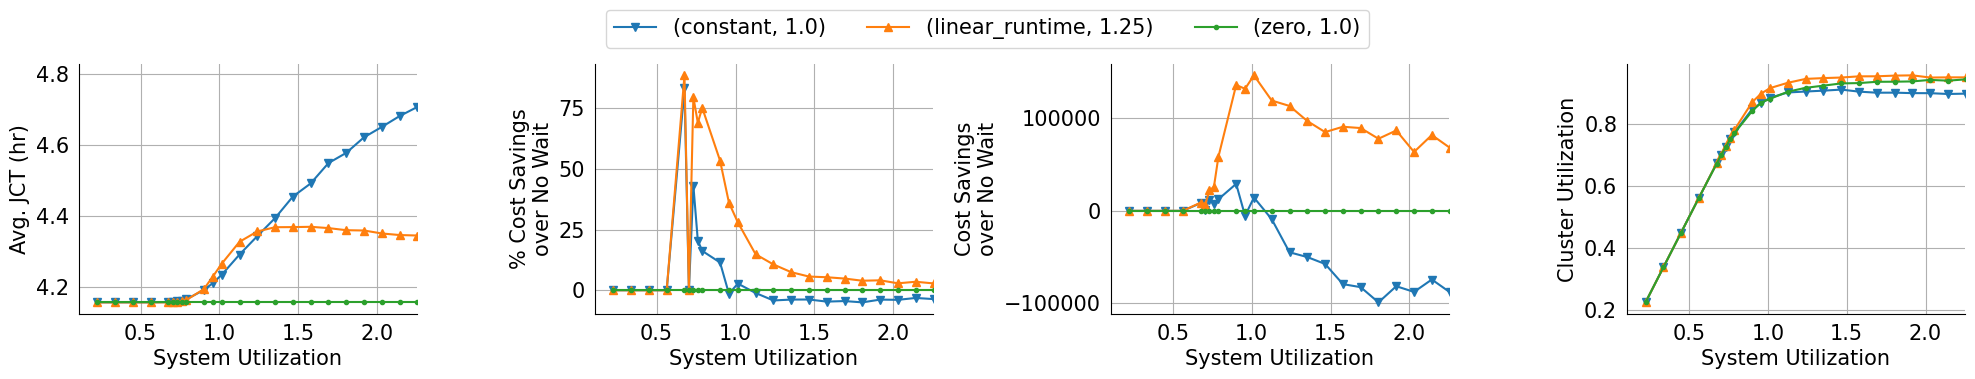

CV: 1


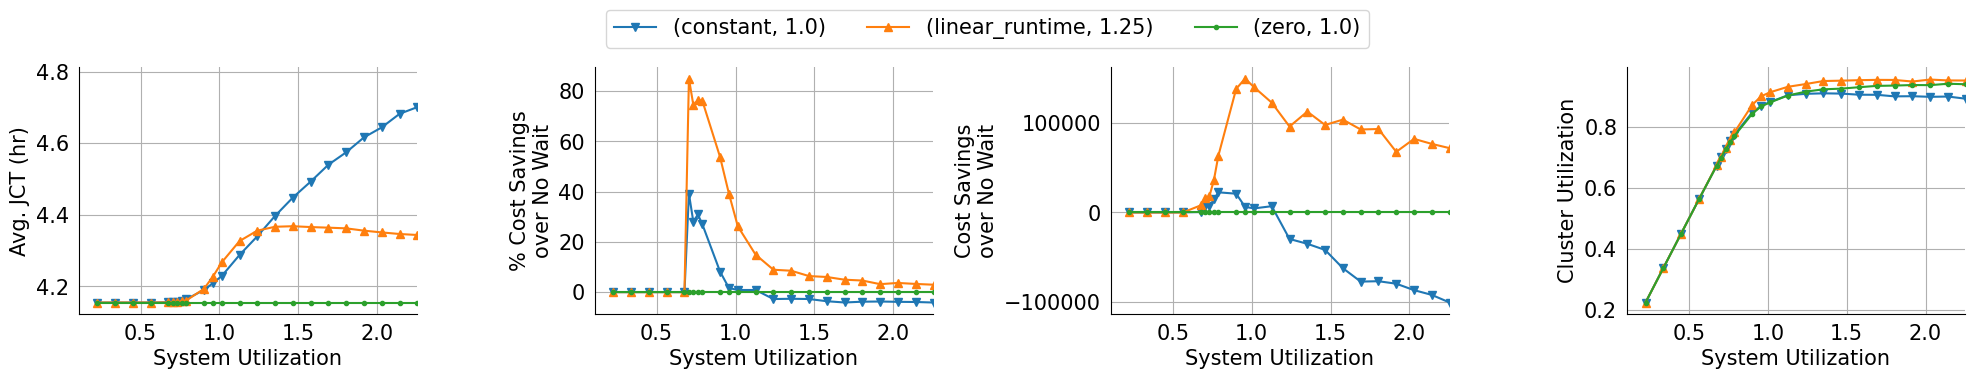

CV: 2


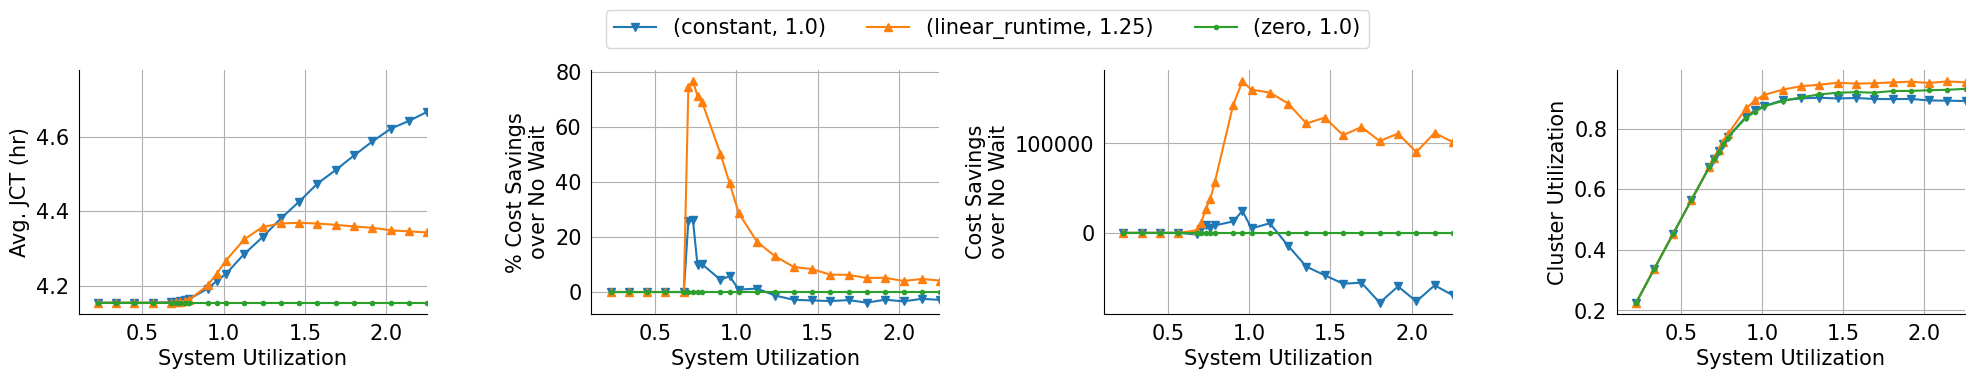

CV: 4


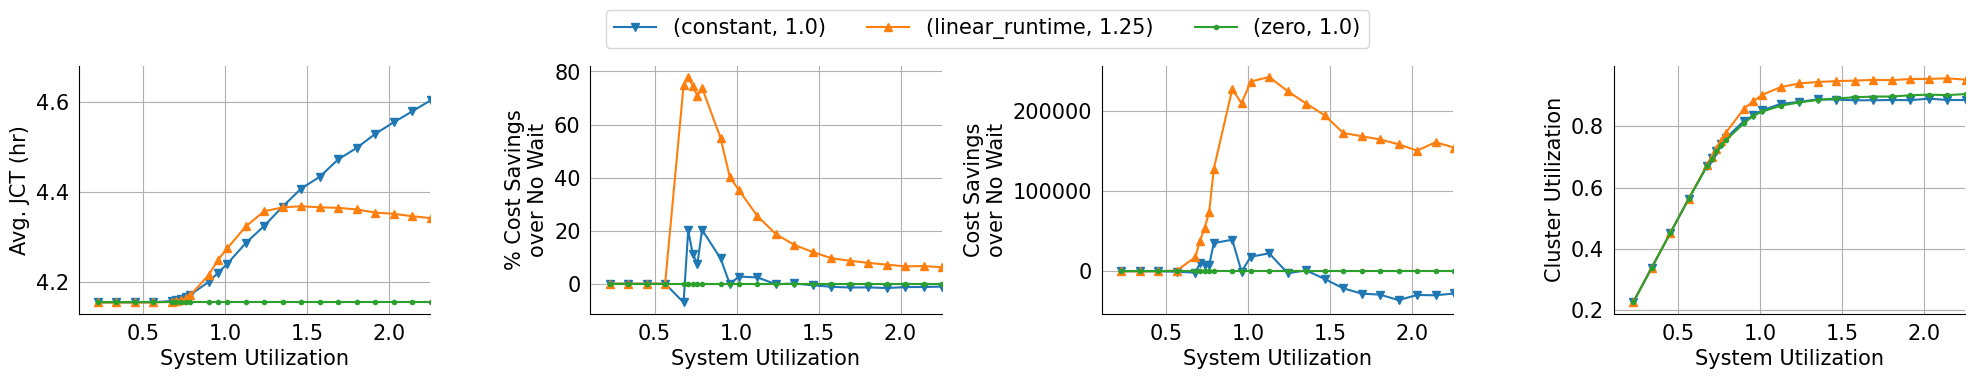

CV: 8


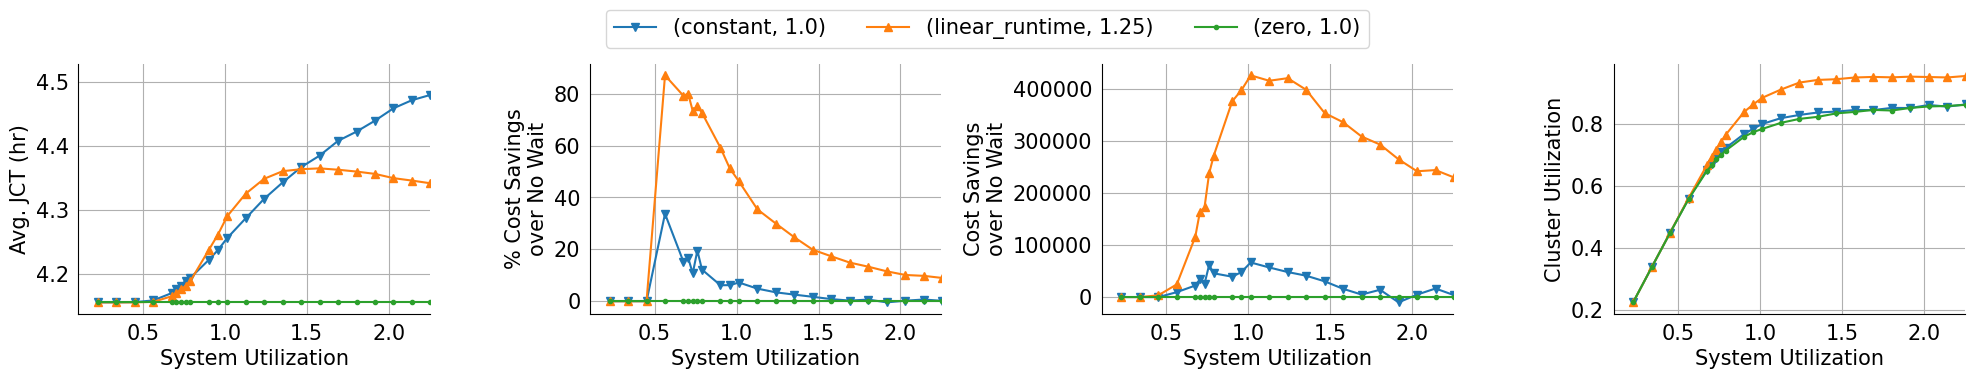

CV: 16


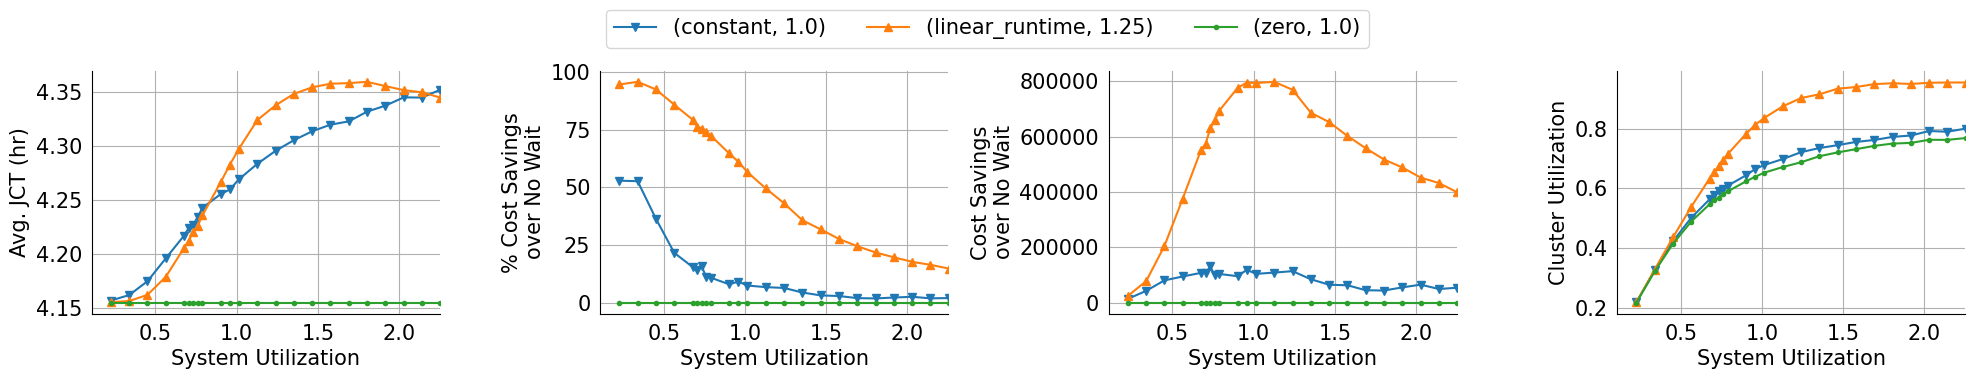

In [177]:
for cv in [0.5, 1, 2, 4, 8, 16]:
    print(f'CV: {cv}')
    simulator_plotting_fn(cv_df, df_filter={
        'cv_factor': cv,
    },x_axis='arrival_rate', y_axis=['avg_jct','cost_mult', 'cost_diff', 'cluster_utilization'], \
                      groupby_values=['waiting_policy', 'waiting_factor'], normalize_x_axis=True)

In [2]:
from skyburst import job_gen

In [19]:
proc_jobs = job_gen.load_processed_jobs({'dataset': 'helios'})

In [20]:
gpu_dict={}

gpu_cost_dict={}

counter = 0
for j in proc_jobs:
    if j.num_gpus not in gpu_dict:
        gpu_dict[j.num_gpus] = 0
        gpu_cost_dict[j.num_gpus] =0
    
#     if j.num_gpus==0 and counter < 2000:
#         print(j)
#         counter+=1
    
    gpu_dict[j.num_gpus]+=1
    gpu_cost_dict[j.num_gpus] += j.cost
    
print(proc_jobs[-1])

Job(idx=170383, resources={'GPUs': 0, 'CPUs': 128}, arr=4651.911388888889, run = 0.011944444444444445, deadline=0.0, start=None)



In [22]:
import collections
gpu_dict = collections.OrderedDict(sorted(gpu_dict.items()))
gpu_cost_dict = collections.OrderedDict(sorted(gpu_cost_dict.items()))


print(gpu_dict)
print(gpu_cost_dict)


OrderedDict([(0, 104433), (1, 37593), (2, 2272), (3, 68), (4, 4046), (5, 31), (6, 78), (7, 53), (8, 17182), (12, 1), (16, 2263), (24, 365), (32, 1462), (40, 127), (48, 83), (56, 28), (64, 81), (72, 13), (80, 38), (96, 3), (104, 10), (112, 3), (120, 48), (128, 71), (144, 9), (160, 23)])
OrderedDict([(0, 1533.8646383640007), (1, 89206.29993710575), (2, 33775.91418238997), (3, 306.1262054507336), (4, 83647.5782547165), (5, 158.0540566037736), (6, 2206.6504245283004), (7, 733.5572746331236), (8, 545194.6663207528), (12, 2.8664150943396227), (16, 356994.9314884694), (24, 23255.044025157207), (32, 515880.24771488743), (40, 20425.631865828094), (48, 13010.262641509442), (56, 45561.33174004193), (64, 55382.22624737947), (72, 3066.541132075472), (80, 890.4394129979033), (96, 14.172578616352203), (104, 5429.843270440251), (112, 1964.3590775681341), (120, 1770.7509433962266), (128, 31723.883605870018), (144, 147.60452830188677), (160, 118563.81551362682)])
